In [1]:
#import some necessary librairies

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


from scipy import stats
from scipy.stats import norm, skew #for some statistics


pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points


from subprocess import check_output
print(check_output(['ls']).decode("utf8")) #check the files available in the directory

data_description.txt
sample_submission.csv
test.csv
TrabalhoHeraldo2018.ipynb
train.csv



/usr/lib/python3/dist-packages/matplotlib/__init__.py:874: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/usr/lib/python3/dist-packages/matplotlib/__init__.py:894: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
#Now let's import and put the train and test datasets in  pandas dataframe
desc  = open('./data_description.txt', 'r')
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
print(desc.read())

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

In [3]:
# Pequena olhada nos dados de treino
train.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [4]:
# Pequena olhada nos dados de test
test.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal


In [5]:
# Checando se todas as colunas estão iguais em todos os datasets
# Percebi que a única diferença é a coluna de target de preço.
for col in train.columns:
    if col not in test.columns:
        print("Não tem as mesmas colunas.", col)

Não tem as mesmas colunas. SalePrice


In [6]:
#check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (1460, 81) 
The test data size before dropping Id feature is : (1459, 80) 

The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


### Processamento de dados ( Eliminando colunas vaizas, dados irrelevantes, outliers etc.)

#### a.Visualização dos dados e tratamento de outliers extremos

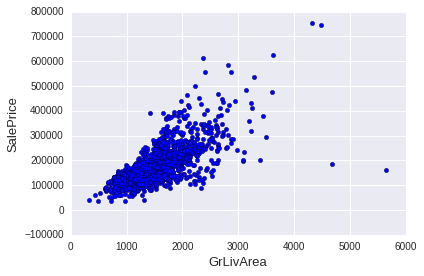

In [7]:
# Plot simples dos dados.
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

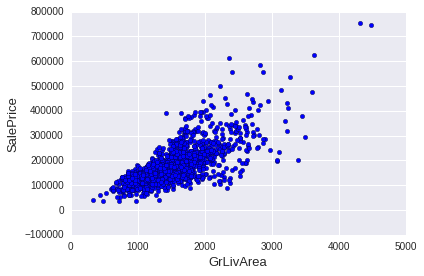

In [8]:
# Deletando outliers que podem prejudicar o modelo
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

# Avaliando grafico de preços por área
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

#### b.Dados estatísticos


 mu = 180932.92 and sigma = 79467.79



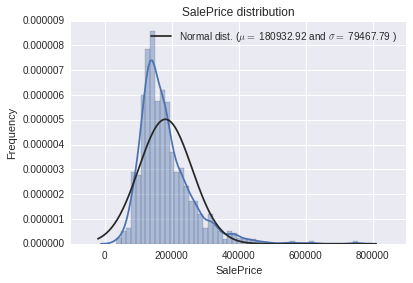

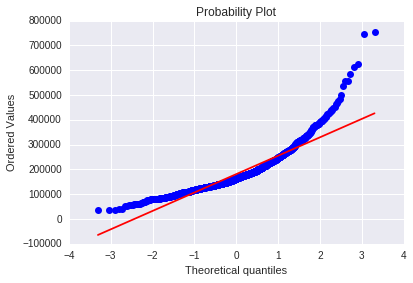

In [9]:
# Sabemos que preditores lineares tem distribuição linear, assim
# Temos que ver como está a distribuição dos nossos dados e adaptalos para distribuição mais próxima
# Da normal possível

# Plotando a distribuição dos dados.
sns.distplot(train['SalePrice'] , bins=50,fit=norm);

# Adquirindo o mu e sigma dos dados.
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# Legenda das distribuições
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

##### b1.Alinhando a distribuição dos dados


 mu = 12.02 and sigma = 0.40



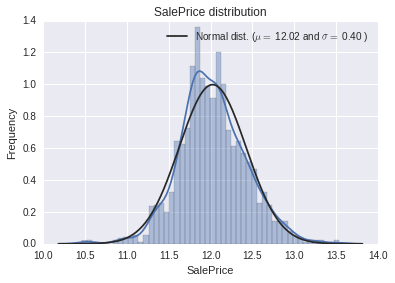

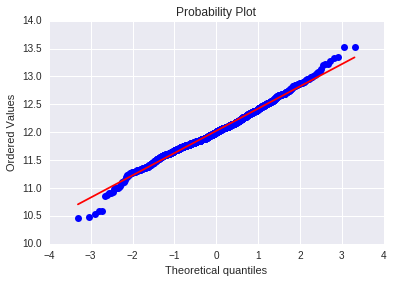

In [10]:
# Usaremos a função log1p para alinhar a distribuição dos nossos targets para que o modelo tenha uma precisão melhor
train["SalePrice"] = np.log1p(train["SalePrice"])

# Visualizando a distribuição após melhoria na organização dos targets
sns.distplot(train['SalePrice'] , bins=50,fit=norm);

# Adquirindo o mu e sigma para a curva de distribuição
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# Ajustando a legenda de distribuição
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

#### c.Caracterizando Features

In [11]:
# Vamos tratar todos os nossos dados de uma vez só.

ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("Tamanho total dos datasets : {}".format(all_data.shape))

Tamanho total dos datasets : (2917, 79)


In [12]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
FireplaceQu,48.680
LotFrontage,16.661
GarageQual,5.451
GarageCond,5.451
GarageFinish,5.451
GarageYrBlt,5.451


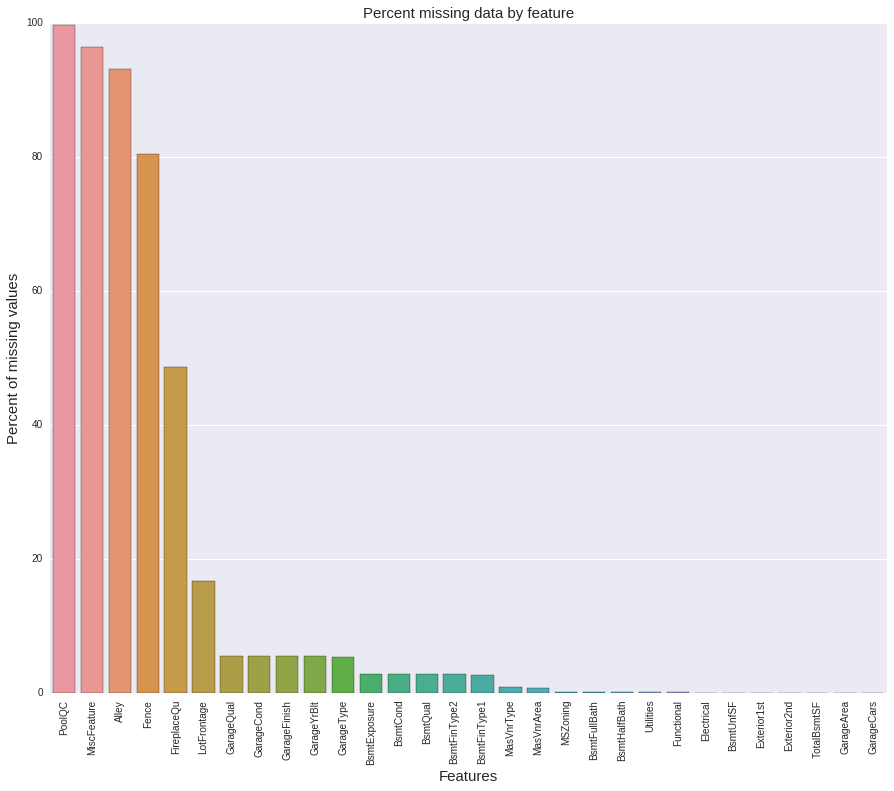

In [13]:
# Apenas um plot bonito no seaborn
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

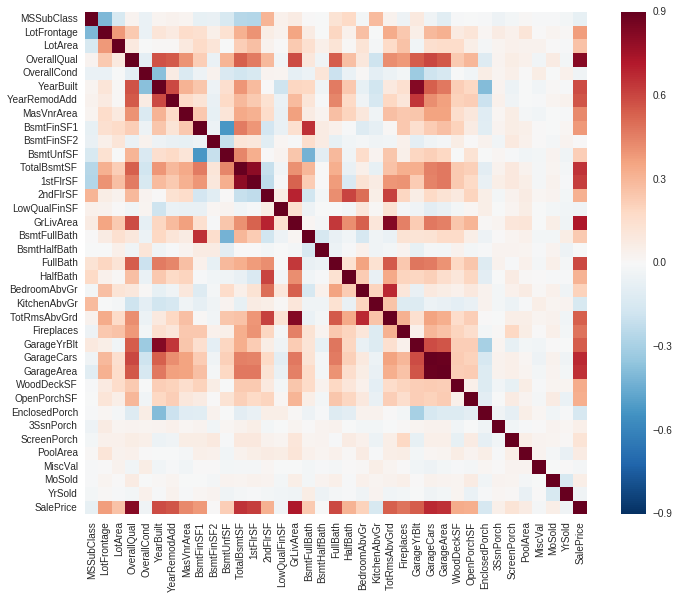

In [14]:
# Heatmap de correlação dos dados

corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

#### d.Tratando dados faltantes.

#### d1.Dados que são vazios de fato

In [15]:
# Dados que quando faltam significa a AUSENCIA do parâmetro
# Tentar substituir por um valor como -1 para ver como o modelo reage a esse outlier

for col in ('Alley', # Não tem acesso por Alley (Beco)
            'BsmtQual', # Não tem porão
            'BsmtCond', # Não tem porão
            'BsmtExposure', # Não tem porão
            'BsmtFinType1', # Não tem porão
            'BsmtFinType2', # Não tem porão
            'Fence', # Não tem cerca
            'FireplaceQu', # Não tem lareira
            'GarageType', # Não tem garagem
            'GarageFinish', # Não tem garagem
            'GarageQual', # Não tem garagem
            'GarageCond', # Não tem garagem
            'MasVnrType', # Não tem alvenaria
            'MiscFeature',  # Não tem miscelanious
            'MSSubClass', # A Casa não possui um tipo definido ??? Será que é apartamento ?            
            'PoolQC'): # Não tem piscina
    all_data[col] = all_data[col].fillna('None')

In [16]:
# Dados que quando faltam significa que possuem valor ZERO

for col in ('BsmtFinSF1', # Não possui porão então a área do mesmo é ZERO
            'BsmtFinSF2', # Não possui porão então a área do mesmo é ZERO
            'BsmtUnfSF', # Não possui porão então a área do mesmo é ZERO            
            'BsmtFullBath', # Não possui porão então a área do mesmo é ZERO
            'BsmtHalfBath', # Não possui porão então a área do mesmo é ZERO
            'GarageYrBlt', # Não possui garagem então a área do mesmo é ZERO
            'GarageArea', # Não possui garagem então a área do mesmo é ZERO
            'GarageCars', # Não possui garagem então a área do mesmo é ZERO
            'MasVnrArea', # Não possui alvenaria então a área do mesmo é ZERO
            'TotalBsmtSF'): # Não possui porão então a área do mesmo é ZERO
    all_data[col] = all_data[col].fillna(0)

#### d2.Dados que estão vazios por erro, mas são calculáveis a partir de outros

In [17]:
# LotFrontage diz respeito ao tamanho da rua ligada a propriedade, logo
# Podemos obter esse valor a partir dos vizinhos dessa pessoa. No caso fizemos a média.
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [18]:
# Como é um dado não muito importante e são poucos casos preenchemos os buracos com a moda.
for col in ('Electrical', 
            'MSZoning',
            'KitchenQual',
            'Exterior1st',
            'Exterior2nd',
            'SaleType'):
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

In [19]:
# Como não sabemos o que estava acontecendo com a funcionalidade nesses casos
# preenchemos com o Typ, que é "Funcionalidade tipica."
all_data["Functional"] = all_data["Functional"].fillna("Typ")

#### d3.Dados inúteis

In [20]:
# Dados inúteis
all_data = all_data.drop(['Utilities'], axis=1)

In [21]:
# Vendo se ainda existe dados faltantes 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


#### e.Feature engineering

In [22]:
# Variáveis numerícas que são categóricas
# Vamos transformalas em strings e depois usar HotEncoder para codifica-las

# MSSubClass é a classe do prédio
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

# Transformando em string variável categórica : Rates(0 - 10) the overall condition of the house
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

# Mes e ano também são transformados em string para serem tratados pelo hotEncoder
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [23]:
# Usando labelEncoder para cada uma das colunas abaixo
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape para vermos que nada mudou, só estamos preparando as variáveis categóricas.        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 78)


In [24]:
# Avaliar variáveis mais importantes aqui! Pode ser com PCA

In [25]:
# Adicionando informação de área total da casa. Primeiro andar, Porão, e segundo andar.
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

# Adicionando informação do percentual do terreno usado para habitação
all_data['PercntLiv'] =  (all_data['GrLivArea']/all_data['LotArea'])*100

#### e1.Skewed features

In [26]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372
LandSlope,4.973
KitchenAbvGr,4.301
BsmtFinSF2,4.145
EnclosedPorch,4.002
ScreenPorch,3.945


#### e1.Tratando skewed features (Aplicando log + 1 em todas as que tem mais de 75% de desvio) 

In [27]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
#all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 60 skewed numerical features to Box Cox transform


#### f.Transformando parâmetros categóricos em colunas linearmente independentes.

In [28]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 221)


In [29]:
# Separando novamente os dados de treino e teste após serem tratados.
train = all_data[:ntrain]
test = all_data[ntrain:]

### Aplicando modelos

In [47]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import make_scorer
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.metrics import r2_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn



import matplotlib.pyplot as plt

def plot_hist_values_x_predictions(values, predictions):
    %pylab inline
    pylab.rcParams['figure.figsize'] = (10, 7)
    plt.hist([values, predictions], label=['Sale Price', 'Prediction'], bins=50)
    plt.legend(loc='upper right')
    plt.figure(figsize=(10,7))
    plt.show()

import xgboost as xgb
import lightgbm as lgb

##### função para fazer validação cruzada

In [48]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train2.values, y_train2, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [49]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(
                            train, y_train, test_size=0.33, random_state=42)

,R Square Score,RMSE
ElasticNet,0.913,0.115
Bayesian Ridge,0.910,0.118
LightGBM,0.910,0.118
KernelRidgeRegressor,0.909,0.118
GradientBoosting,0.907,0.121
Hubber,0.905,0.122
Ridge,0.904,0.122
Lasso,0.903,0.122
XGBoost,0.902,0.124
SVM Linear,0.890,0.132


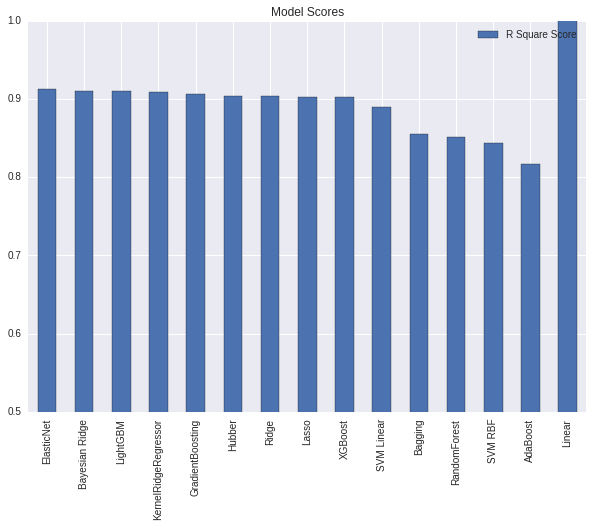

In [68]:
# R2 Score
def lets_try(train,labels):
    results={}
    def test_model(clf):
        
        cv = KFold(n_splits=5,shuffle=True,random_state=45)
        r2 = make_scorer(r2_score)
        r2_val_score = cross_val_score(clf, train, labels, cv=cv,scoring=r2)
        scores=[r2_val_score.mean()]
        return scores

    def rmsle_cv(model):
        kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
        rmse= np.sqrt(-cross_val_score(model, X_train2.values, y_train2, scoring="neg_mean_squared_error", cv = kf))
        return(rmse.mean())
    
    results_rmsle={}
    
    clf = linear_model.LinearRegression()
    results["Linear"]=test_model(clf)
    results_rmsle["Linear"] = rmsle_cv(clf)
    
    clf = linear_model.Ridge()
    results["Ridge"]=test_model(clf)
    results_rmsle["Ridge"] = rmsle_cv(clf)
    
    clf = linear_model.BayesianRidge()
    results["Bayesian Ridge"]=test_model(clf)
    results_rmsle["Bayesian Ridge"] = rmsle_cv(clf)
    
    
    clf = linear_model.HuberRegressor()
    results["Hubber"]=test_model(clf)
    results_rmsle["Hubber"] = rmsle_cv(clf)
    
    
    clf = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
    results["ElasticNet"]=test_model(clf)
    results_rmsle["ElasticNet"] = rmsle_cv(clf)
    
    
    clf = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
    results["KernelRidgeRegressor"]=test_model(clf)
    results_rmsle["KernelRidgeRegressor"] = rmsle_cv(clf)
    
    
    clf = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
    results["GradientBoosting"]=test_model(clf)
    results_rmsle["GradientBoosting"] = rmsle_cv(clf)
    
    
    clf = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
    results["XGBoost"]=test_model(clf)
    results_rmsle["XGBoost"] = rmsle_cv(clf)
    
    
    clf = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
    results["LightGBM"]=test_model(clf)
    results_rmsle["LightGBM"] = rmsle_cv(clf)
    
    
    clf = linear_model.Lasso(alpha=1e-4)
    results["Lasso"]=test_model(clf)
    results_rmsle["Lasso"] = rmsle_cv(clf)
    
    
    clf = BaggingRegressor()
    results["Bagging"]=test_model(clf)
    results_rmsle["Bagging"] = rmsle_cv(clf)
    
    
    clf = RandomForestRegressor()
    results["RandomForest"]=test_model(clf)
    results_rmsle["RandomForest"] = rmsle_cv(clf)
    
    
    clf = AdaBoostRegressor()
    results["AdaBoost"]=test_model(clf)
    results_rmsle["AdaBoost"] = rmsle_cv(clf)
    
    
    clf = svm.SVR()
    results["SVM RBF"]=test_model(clf)
    results_rmsle["SVM RBF"] = rmsle_cv(clf)
    
    
    clf = svm.SVR(kernel="linear")
    results["SVM Linear"]=test_model(clf)
    results_rmsle["SVM Linear"] = rmsle_cv(clf)
    
    
    results = pd.DataFrame.from_dict(results,orient='index')
    results.columns=["R Square Score"]
    results=results.sort_values(["R Square Score"],ascending=False)
    
    results_rmsle = pd.DataFrame.from_dict(results_rmsle,orient='index')
    results_rmsle.columns=["RMSE"]
    results_rmsle=results_rmsle.sort_values(["RMSE"],ascending=False)
    
    result = pd.concat([results, results_rmsle], axis=1, join='inner')
    
    results.plot(kind="bar",title="Model Scores")    
    axes = plt.gca()
    axes.set_ylim([0.5,1])
    
    return result

lets_try(X_train2,y_train2)

In [33]:
regr = linear_model.LinearRegression()
regBay = linear_model.BayesianRidge()
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                  max_depth=4, max_features='sqrt',
                                  min_samples_leaf=15, min_samples_split=10, 
                                  loss='huber', random_state =5)

model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                            learning_rate=0.05, max_depth=3, 
                            min_child_weight=1.7817, n_estimators=2200,
                            reg_alpha=0.4640, reg_lambda=0.8571,
                            subsample=0.5213, silent=1,
                            random_state =7, nthread = -1)

model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)



#### Linear Regression 


Linear Regression score: 41485881.3261 (61050729.4312)

Mean squared error: 80264605029937152.00
Variance score: -511244198497928640.00
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test', 'f', 'norm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


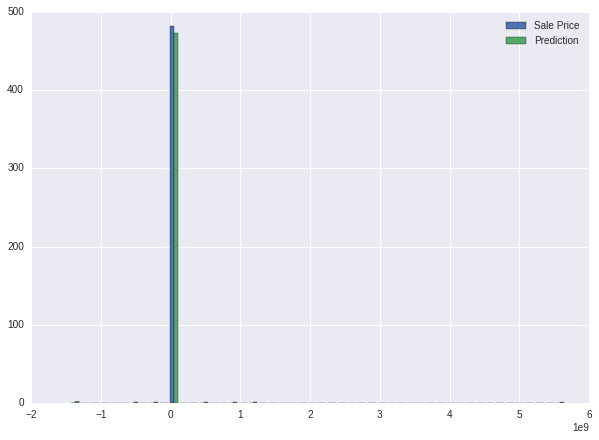

In [34]:
score = rmsle_cv(regr)
print("\nLinear Regression score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

# Fitting model
regr.fit(X_train2, y_train2)

# Make predictions using the testing set
house_y_pred = regr.predict(X_test2)

print("Mean squared error: %.2f"
      % mean_squared_error(y_test2, house_y_pred))

print('Variance score: %.2f' % r2_score(y_test2, house_y_pred))
plot_hist_values_x_predictions(y_test2,house_y_pred)

#### Bayesian Ridge Regression


Linear Regression score: 0.1179 (0.0095)

Mean squared error: 0.01
Variance score: 0.91
Populating the interactive namespace from numpy and matplotlib


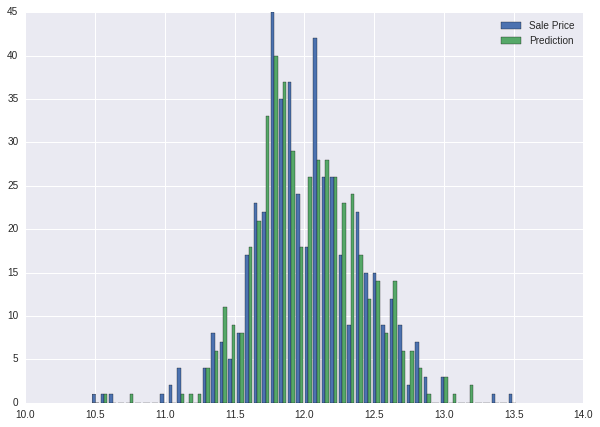

In [35]:
from sklearn import linear_model

score = rmsle_cv(regBay)
print("\nLinear Regression score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

# Fitting model
regBay.fit(X_train2, y_train2)

# Make predictions using the testing set
house_y_pred = regBay.predict(X_test2)

print("Mean squared error: %.2f"
      % mean_squared_error(y_test2, house_y_pred))

print('Variance score: %.2f' % r2_score(y_test2, house_y_pred))
plot_hist_values_x_predictions(y_test2,house_y_pred)


#### LASSO Regression


Lasso score: 0.1149 (0.0105)

Mean squared error: 0.01
Variance score: 0.92
Populating the interactive namespace from numpy and matplotlib


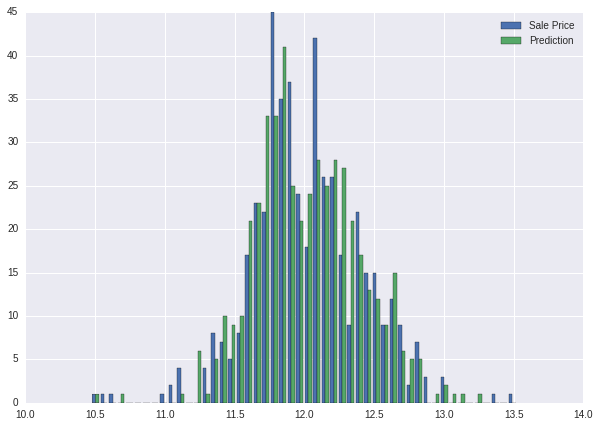

In [36]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

# Fitting model
lasso.fit(X_train2, y_train2)

# Make predictions using the testing set
house_y_pred = lasso.predict(X_test2)

print("Mean squared error: %.2f"
      % mean_squared_error(y_test2, house_y_pred))

print('Variance score: %.2f' % r2_score(y_test2, house_y_pred))
plot_hist_values_x_predictions(y_test2,house_y_pred)


#### Elastic Net Regression

ElasticNet score: 0.1148 (0.0101)

Mean squared error: 0.01
Variance score: 0.92
Populating the interactive namespace from numpy and matplotlib


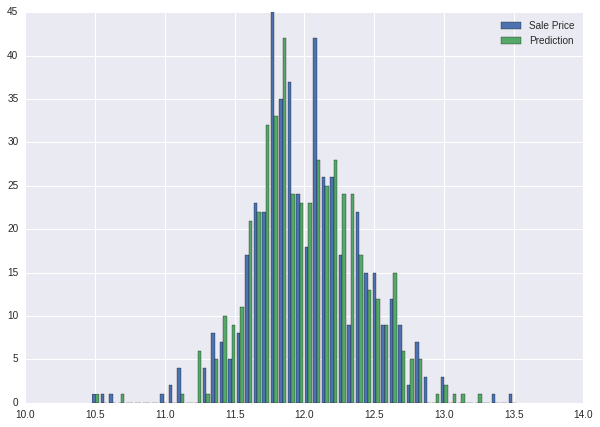

In [37]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

# Fitting model
ENet.fit(X_train2, y_train2)

# Make predictions using the testing set
house_y_pred = ENet.predict(X_test2)

print("Mean squared error: %.2f"
      % mean_squared_error(y_test2, house_y_pred))

print('Variance score: %.2f' % r2_score(y_test2, house_y_pred))
plot_hist_values_x_predictions(y_test2,house_y_pred)


#### Kernel Ridge Regression

Kernel Ridge score: 0.1184 (0.0101)

Mean squared error: 0.01
Variance score: 0.91
Populating the interactive namespace from numpy and matplotlib


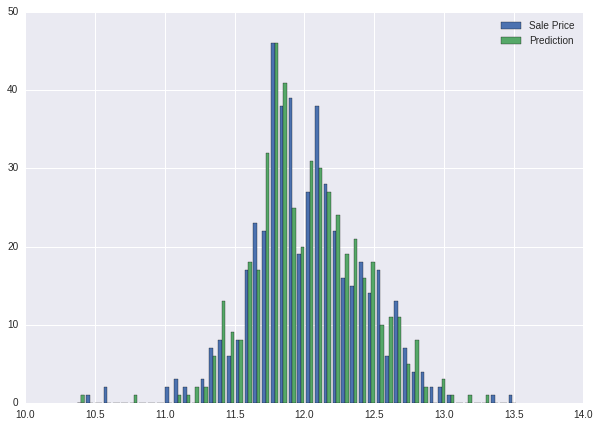

In [38]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

# Fitting model
KRR.fit(X_train2, y_train2)

# Make predictions using the testing set
house_y_pred = KRR.predict(X_test2)

print("Mean squared error: %.2f"
      % mean_squared_error(y_test2, house_y_pred))

print('Variance score: %.2f' % r2_score(y_test2, house_y_pred))
plot_hist_values_x_predictions(y_test2,house_y_pred)


#### Gradient Boosting Regression

Gradient Boosting score: 0.1207 (0.0122)

Mean squared error: 0.01
Variance score: 0.91
Populating the interactive namespace from numpy and matplotlib


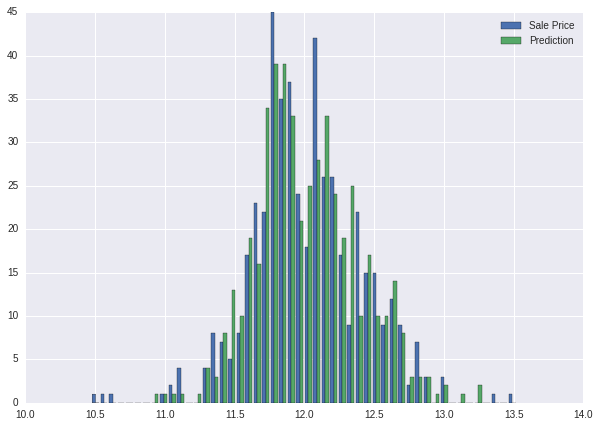

In [39]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

# Fitting model
GBoost.fit(X_train2, y_train2)

# Make predictions using the testing set
house_y_pred = GBoost.predict(X_test2)

print("Mean squared error: %.2f"
      % mean_squared_error(y_test2, house_y_pred))

print('Variance score: %.2f' % r2_score(y_test2, house_y_pred))
plot_hist_values_x_predictions(y_test2,house_y_pred)

#### XGBoost

Xgboost score: 0.1240 (0.0127)

Mean squared error: 0.01
Variance score: 0.91
Populating the interactive namespace from numpy and matplotlib


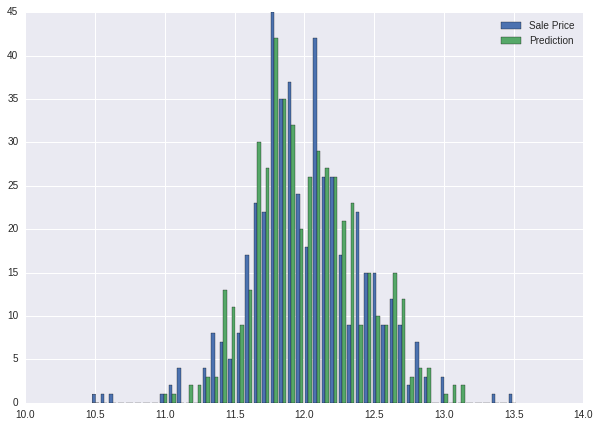

In [40]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

# Fitting model
model_xgb.fit(X_train2, y_train2)

# Make predictions using the testing set
house_y_pred = model_xgb.predict(X_test2)

print("Mean squared error: %.2f"
      % mean_squared_error(y_test2, house_y_pred))

print('Variance score: %.2f' % r2_score(y_test2, house_y_pred))
plot_hist_values_x_predictions(y_test2,house_y_pred)



#### LightGBM

LGBM score: 0.1183 (0.0117)

Mean squared error: 0.01
Variance score: 0.91
Populating the interactive namespace from numpy and matplotlib


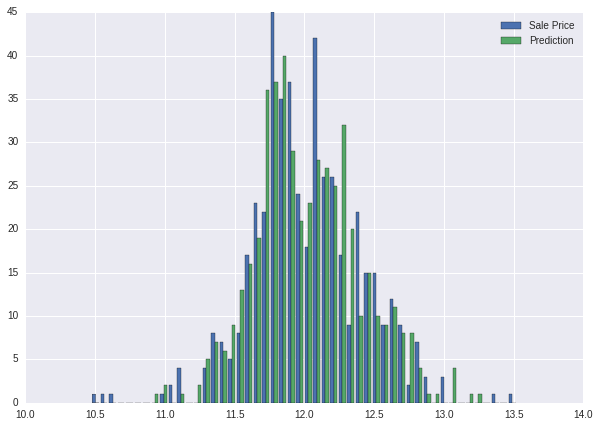

In [41]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

# Fitting model
model_lgb.fit(X_train2, y_train2)

# Make predictions using the testing set
house_y_pred = model_lgb.predict(X_test2)

print("Mean squared error: %.2f"
      % mean_squared_error(y_test2, house_y_pred))

print('Variance score: %.2f' % r2_score(y_test2, house_y_pred))
plot_hist_values_x_predictions(y_test2,house_y_pred)
